In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [44]:
# Read the preprocessed data
import os

pre_file_path = os.path.join('pre_normalized', 'news.csv')
pre_df = pd.read_csv(pre_file_path)
pre_df = pre_df[["text","label"]]
pre_df

,text,label
0,autor bestseller cita 5 expressoes indicam int...,fake
1,juiz df confirma indicios expresidente petista...,fake
2,senhora 60 anos corre atras eduardo cunha aero...,fake
3,russia ameaca derrubar avioes americanos siria...,fake
4,governo podera demitir 18 mil servidores banco...,fake
...,...,...
7195,petistas intervencao serve contornar dificulda...,true
7196,tercafeira 11 julho 2017 boa noite aqui princi...,true
7197,dona marisa exprimeiradama morre sp mulher lul...,true
7198,thiago blumenthal texto agradecimento nobel li...,true


In [45]:
# Split into fake and true news
fake_df = pre_df[pre_df["label"] == 'fake']
true_df = pre_df[pre_df["label"] == 'true']

In [46]:
# Create bag of words for each df
from sklearn.feature_extraction.text import CountVectorizer

fake_bag = CountVectorizer().fit(fake_df["text"])
true_bag = CountVectorizer().fit(true_df["text"])
fake_bag = fake_bag.vocabulary_
true_bag = true_bag.vocabulary_

In [47]:
# Create a bag of words with the difference between the two

# Get all words from both bags
all_words = set(list(fake_bag.keys()) + list(true_bag.keys()))

bag = {}
for word in all_words:
    if word in fake_bag and word in true_bag:
        bag[word] = true_bag[word] - fake_bag[word]
    elif word in fake_bag:
        bag[word] = -fake_bag[word]
    else:
        bag[word] = true_bag[word]


In [48]:
worst_to_best = sorted(bag.items(), key= lambda x: x[1])

print(f"worst word: {worst_to_best[0]}")
print(f"best word: {worst_to_best[-1]}")

worst word: ('zumbis', -34089)
best word: ('zygmunt', 34125)


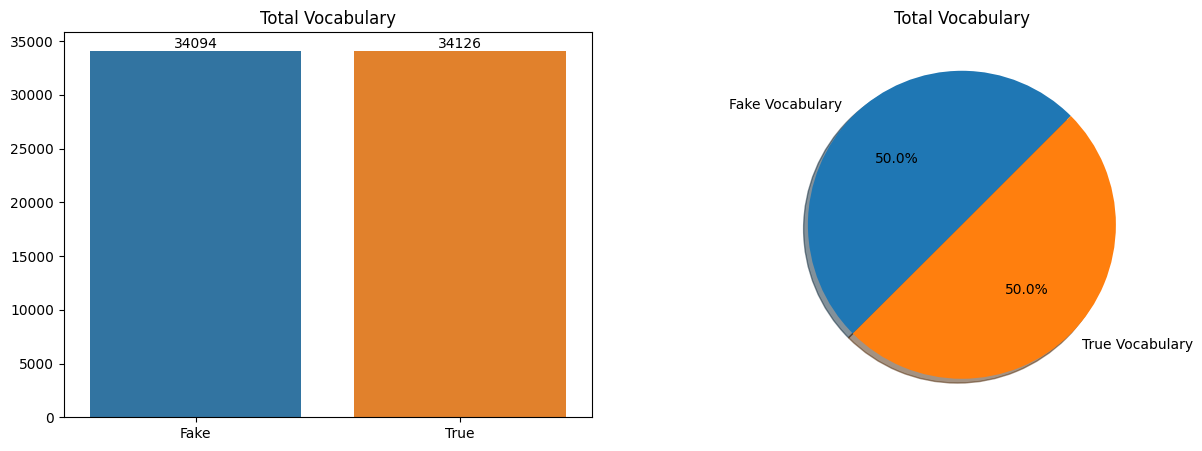

In [49]:
# Total vacubulary for each bag
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.ravel()
sns.barplot(x=["Fake", "True"], y=[len(fake_bag), len(true_bag)], ax = axes[0])
axes[0].bar_label(axes[0].containers[0], label_type='edge', fmt='%d', color='black')
axes[0].title.set_text("Total Vocabulary")


axes[1].pie([len(fake_bag), len(true_bag)], labels=["Fake Vocabulary", "True Vocabulary"], autopct='%1.1f%%', shadow=True, startangle= 45)
axes[1].title.set_text("Total Vocabulary")

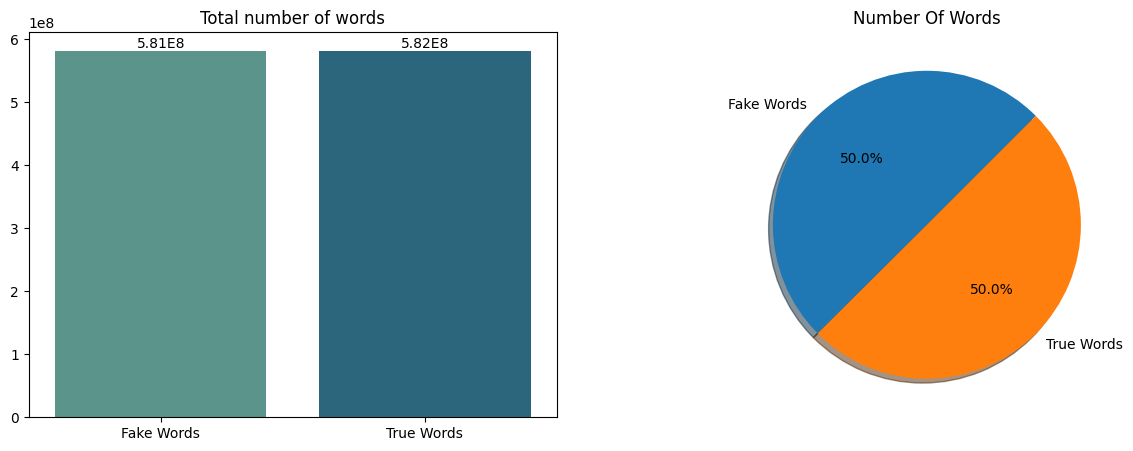

In [50]:
numberOfFakeWords = sum(fake_bag.values())
numberOfTrueWords = sum(true_bag.values())
numberOfWords = numberOfFakeWords + numberOfTrueWords

def my_fmt(x):
    return f"{x/10**8:.2f}E8"

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.ravel()
sns.barplot(x=["Fake Words", "True Words"], y=[numberOfFakeWords, numberOfTrueWords], ax = axes[0])
axes[0].bar_label(axes[0].containers[0], label_type='edge', fmt= my_fmt, color='black')
axes[0].title.set_text("Total number of words")


axes[1].pie([numberOfFakeWords, numberOfTrueWords], labels=["Fake Words", "True Words"], autopct='%1.1f%%', shadow=True, startangle= 45)
axes[1].title.set_text("Number Of Words")

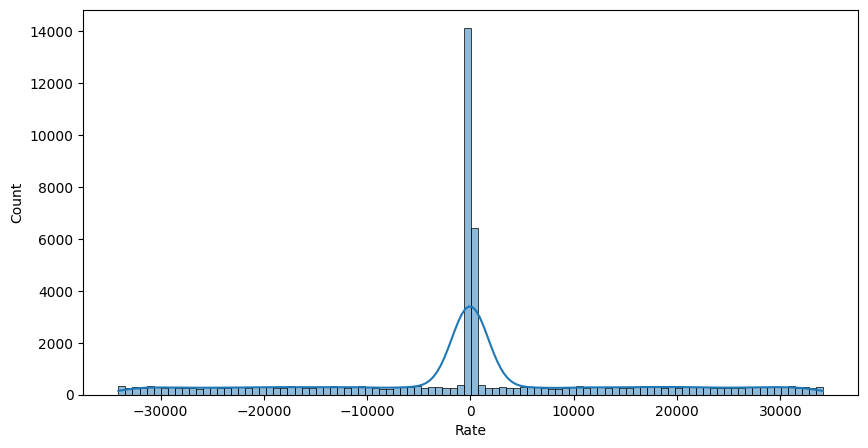

In [51]:
distribution_df = pd.DataFrame(bag.values(), columns=["Rate"])
distribution_df

# Create a histogram of the distribution
plt.figure(figsize=(10,5))
sns.histplot(distribution_df["Rate"], bins=100, kde=True)
plt.show()

In [52]:
normalized_fake_bag = {}
for word in fake_bag:
    normalized_fake_bag[word] = fake_bag[word] / numberOfFakeWords

normalized_true_bag = {}
for word in true_bag:
    normalized_true_bag[word] = true_bag[word] / numberOfTrueWords

normalized_bag = {}
for word in all_words:
    if word in normalized_fake_bag and word in normalized_true_bag:
        normalized_bag[word] = normalized_true_bag[word] - normalized_fake_bag[word]
    elif word in fake_bag:
        normalized_bag[word] = -normalized_fake_bag[word]
    else:
        normalized_bag[word] = normalized_true_bag[word]

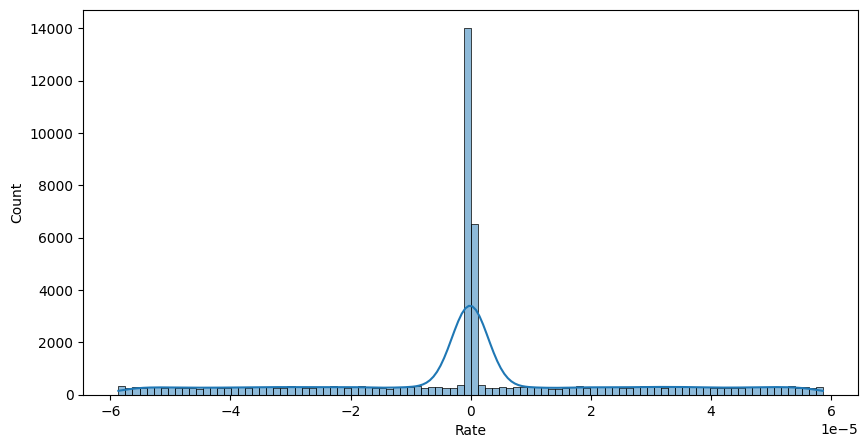

In [53]:
distribution_df = pd.DataFrame(normalized_bag.items(), columns=["Word", "Rate"])
distribution_df

# Create a histogram of the distribution
plt.figure(figsize=(10,5))
sns.histplot(distribution_df["Rate"], bins=100, kde=True)
plt.show()